# Statistics and Visualisations

In [1]:
NAME = "Knudsen"
NAME = "Niedermayer"

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# unpickle the abnormal returns
df_abnormal_returns = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_abnormal_returns.pkl")



# set plotting sizes
tick_size = 15
label_size = 20
title_size = 30
fig_height = 20

EVENT_INDEX = 20 # because 20 [0,..19] are before the event


investigation_periods = {
    "overall": (pd.Timestamp("2018-01-01"), pd.Timestamp("2021-12-31")),
    "pre-pandemic": (pd.Timestamp("2018-01-01"), pd.Timestamp("2020-02-29")),
    "pandemic": (pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31")),
}

with open(f"data/{NAME}/calculate_AR_results/companies.pkl", "rb") as f:
    companies = pickle.load(f)


### Having a look at all trade types together

In [3]:
types_of_interest = ["P - Purchase", "S - Sale", "S - Sale+OE"]
counts = df_abnormal_returns.groupby(level=2).count()[0].rename({0: "N"})
print(f"relevant filings: ",counts[types_of_interest].sum())
print(counts[types_of_interest])
print(f"dropped filings ", counts.sum() - counts[types_of_interest].sum())

relevant filings:  69214
TradeType
P - Purchase    16429
S - Sale        30506
S - Sale+OE     22279
Name: 0, dtype: int64
dropped filings  210986


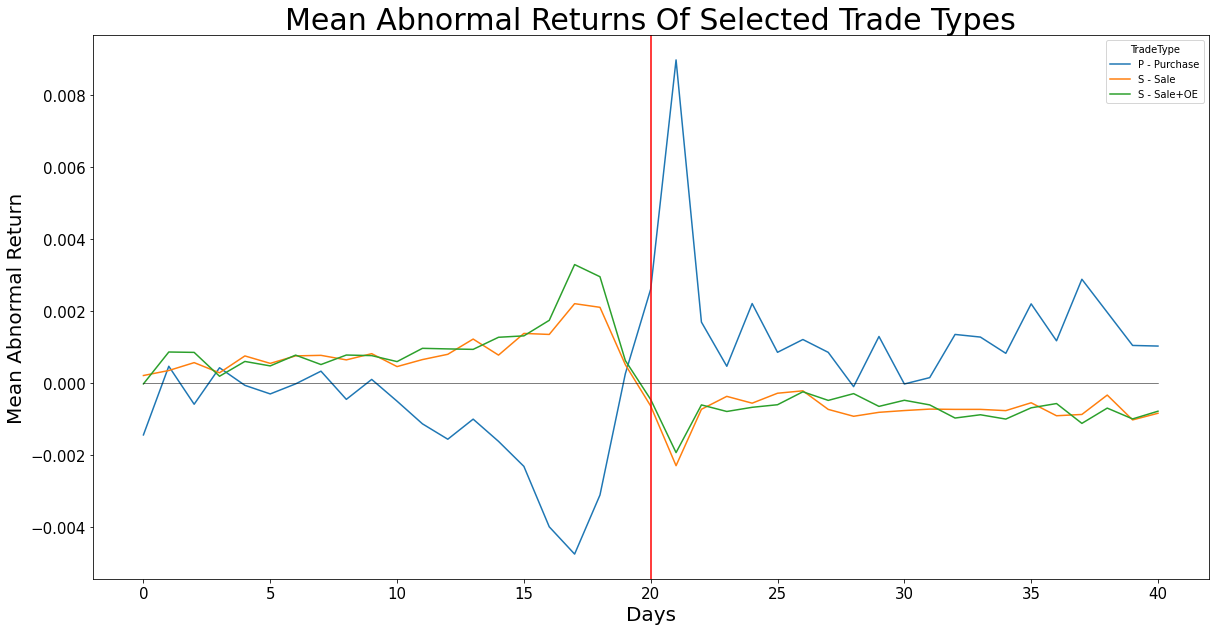

In [4]:
a = df_abnormal_returns.loc[:,:,types_of_interest,:].groupby(level=[2]).mean().transpose().plot(figsize=(fig_height, 10))
plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
a.set_title("Mean Abnormal Returns Of Selected Trade Types",fontsize=title_size)
a.set_xlabel("Days", fontsize=label_size)
a.set_ylabel("Mean Abnormal Return", fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
plt.savefig(f"data/{NAME}/visualisations/MAR_selected_tradetypes.png", dpi=600, bbox_inches='tight')

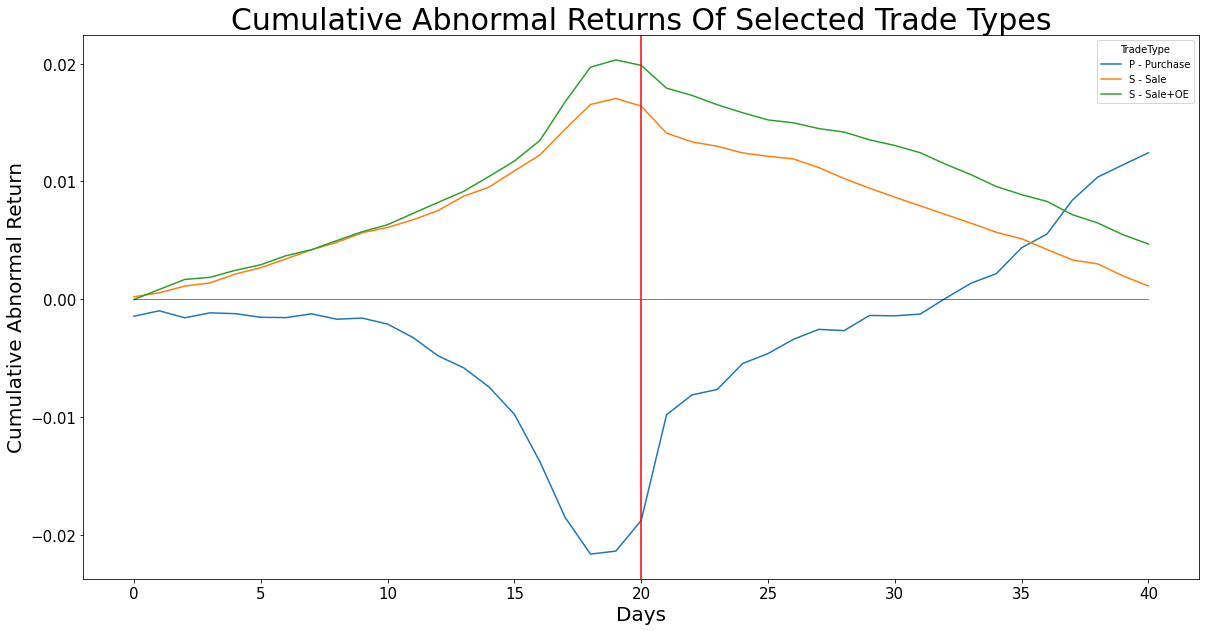

In [5]:
a = df_abnormal_returns.loc[:,:,types_of_interest,:].groupby(level=[2]).mean().transpose().cumsum().plot(figsize=(fig_height, 10))
plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
a.set_title("Cumulative Abnormal Returns Of Selected Trade Types",fontsize=title_size)
a.set_xlabel("Days", fontsize=label_size)
a.set_ylabel("Cumulative Abnormal Return", fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
plt.savefig(f"data/{NAME}/visualisations/CAR_selected_tradetypes.png", dpi=600, bbox_inches='tight')

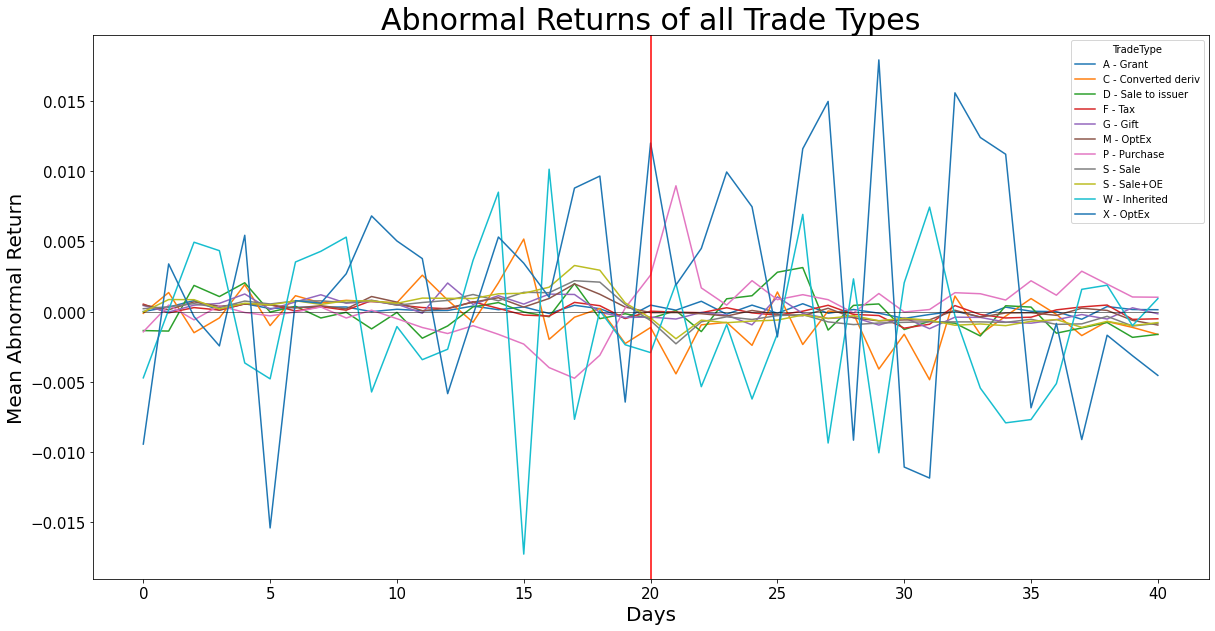

In [6]:
a = df_abnormal_returns.groupby(level=[2]).mean().transpose().plot(figsize=(fig_height, 10), fontsize=15)
plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
a.set_title("Abnormal Returns of all Trade Types",fontsize=title_size)
a.set_xlabel("Days", fontsize=label_size)
a.set_ylabel("Mean Abnormal Return", fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes.png", dpi=600, bbox_inches='tight')

In [7]:
df_abnormal_returns

0         1         2   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.014488  0.020009  0.004322   
        60  A - Grant   2021-12-21       0.014488  0.020009  0.004322   
        61  S - Sale    2021-12-09      -0.028087 -0.001870 -0.010602   
        62  F - Tax     2021-12-03       0.011502  0.001633  0.015117   
        63  M - OptEx   2021-12-03       0.011502  0.001633  0.015117   
...                                           ...       ...       ...   
CPRI    202 S - Sale+OE 2018-03-05       0.010417  0.019999  0.003590   
        203 S - Sale+OE 2018-02-20      -0.012678  0.015631 -0.001285   
        204 S - Sale+OE 2018-02-15       0.005739  0.004195 -0.012704   
        205 M - OptEx   2018-02-15       0.005739  0.004195 -0.012704   
        206 S - Sale+OE 2018-02-15       0.005739  0.004195 -0.012704   

                                               3         4         5   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.003310 -0.009099  0.023843   
        60  A - Grant   2021-12-21       0.003310 -0.009099  0.023843   
        61  S - Sale    2021-12-09       0.000851  0.003322 -0.009983   
        62  F - Tax     2021-12-03      -0.000682 -0.027669 -0.001546   
        63  M - OptEx   2021-12-03      -0.000682 -0.027669 -0.001546   
...                                           ...       ...       ...   
CPRI    202 S - Sale+OE 2018-03-05       0.011790 -0.060064 -0.019021   
        203 S - Sale+OE 2018-02-20      -0.007078  0.003121 -0.007969   
        204 S - Sale+OE 2018-02-15       0.015679 -0.001263 -0.007030   
        205 M - OptEx   2018-02-15       0.015679 -0.001263 -0.007030   
        206 S - Sale+OE 2018-02-15       0.015679 -0.001263 -0.007030   

                                               6         7         8   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.017127 -0.015654  0.016375   
        60  A - Grant   2021-12-21       0.017127 -0.015654  0.016375   
        61  S - Sale    2021-12-09       0.004347 -0.036822  0.013957   
        62  F - Tax     2021-12-03      -0.010316  0.001206  0.003654   
        63  M - OptEx   2021-12-03      -0.010316  0.001206  0.003654   
...                                           ...       ...       ...   
CPRI    202 S - Sale+OE 2018-03-05       0.001492  0.019901 -0.002059   
        203 S - Sale+OE 2018-02-20       0.004688 -0.016342 -0.005430   
        204 S - Sale+OE 2018-02-15       0.003061 -0.007817  0.004874   
        205 M - OptEx   2018-02-15       0.003061 -0.007817  0.004874   
        206 S - Sale+OE 2018-02-15       0.003061 -0.007817  0.004874   

                                               9   ...        31        32  \
Company i   TradeType   event_timestamp            ...                       
SLB     59  A - Grant   2021-12-21      -0.007811  ...  0.018661  0.028383   
        60  A - Grant   2021-12-21      -0.007811  ...  0.018661  0.028383   
        61  S - Sale    2021-12-09       0.019600  ... -0.014792  0.010434   
        62  F - Tax     2021-12-03      -0.009554  ...  0.015301 -0.007760   
        63  M - OptEx   2021-12-03      -0.009554  ...  0.015301 -0.007760   
...                                           ...  ...       ...       ...   
CPRI    202 S - Sale+OE 2018-03-05       0.008664  ...  0.009986  0.004821   
        203 S - Sale+OE 2018-02-20       0.011051  ... -0.008505 -0.022035   
        204 S - Sale+OE 2018-02-15      -0.016283  ... -0.013331 -0.004085   
        205 M - OptEx   2018-02-15      -0.016283  ... -0.013331 -0.004085   
        206 S - Sale+OE 2018-02-15      -0.016283  ... -0.013331 -0.004085   

                                               33        34        35  \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21  

I think OE and OptEx means option exercise. "to exercise" means to put into effect the right to buy or sell the underlying security that is specified in the options contract." Can we be sure that the action does not shift the market, and the swing in return is really due to new information? Are these trades public, so maybe they are used as a signal for traders?

### Boxplot of the sum over all companies's AR

![alt text](assets/images/time_agg.png)

In our case it is not company i, but filing i

Types of trade to pick from:

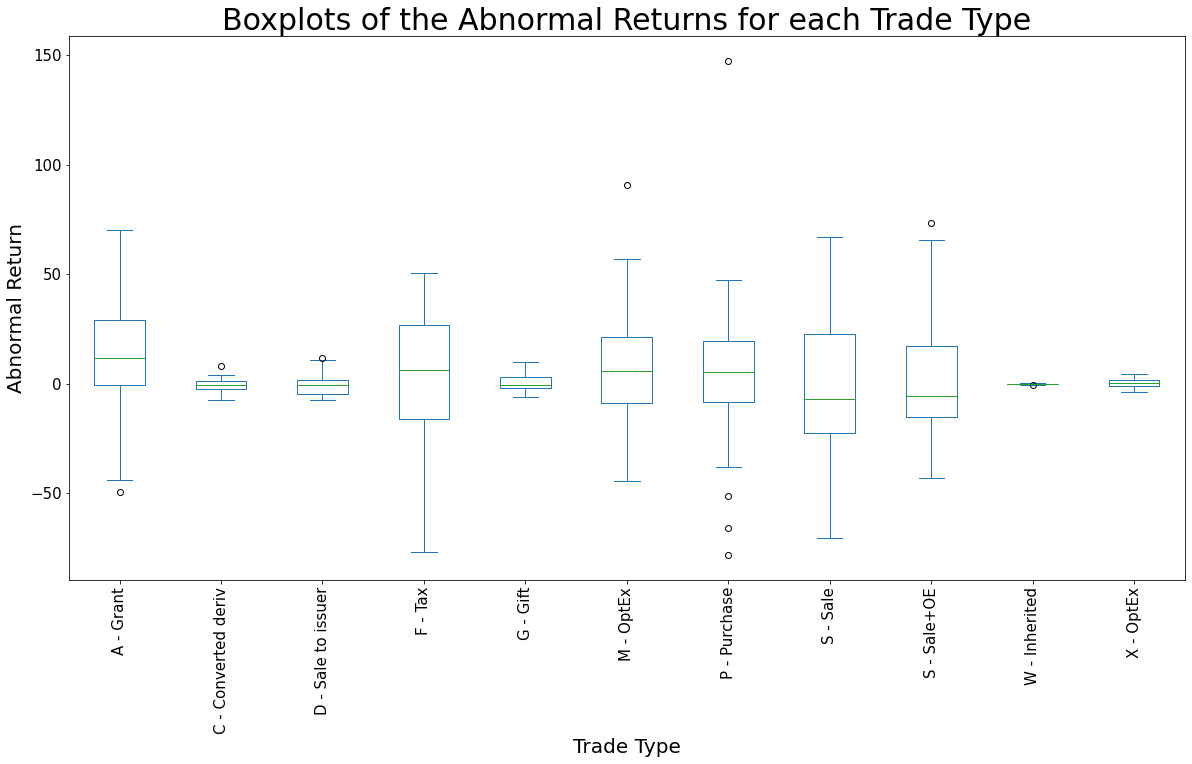

In [8]:
ax = df_abnormal_returns.groupby(level=[2]).sum().transpose().plot.box(rot=90, figsize=(fig_height, 10))
ax.set_title("Boxplots of the Abnormal Returns for each Trade Type",fontsize=title_size)
ax.set_xlabel("Trade Type", fontsize=label_size)
ax.set_ylabel("Abnormal Return", fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes_boxplot.png", dpi=600, bbox_inches='tight')

In [9]:
types = list(set([x[2] for x in df_abnormal_returns.index]))
types

['S - Sale',
 'M - OptEx',
 'F - Tax',
 'G - Gift',
 'D - Sale to issuer',
 'C - Converted deriv',
 'X - OptEx',
 'A - Grant',
 'S - Sale+OE',
 'P - Purchase',
 'W - Inherited']

Specify the type of the trades to investigate

In [10]:
type_ = "P - Purchase" # "S - Sale"
df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]

The index describes the company and the index of the filing in the compnay, the columns represent the days in the event window

In [11]:
df_abnormal_returns_type

0         1         2         3         4   \
Company i   event_timestamp                                                     
SLB     162 2020-09-15      -0.006425 -0.006966  0.006025 -0.040080 -0.008219   
        163 2020-08-06      -0.028556  0.021393 -0.012399  0.060691 -0.019859   
        203 2020-04-01      -0.047837  0.005169 -0.045674 -0.138943 -0.017392   
        204 2020-03-10      -0.006840  0.005789  0.013451 -0.003797 -0.004870   
        205 2020-02-05       0.000940 -0.035174  0.001796  0.004768 -0.027833   
...                               ...       ...       ...       ...       ...   
BHVN    164 2019-06-26       0.013388 -0.041979  0.021102 -0.028722 -0.032314   
        165 2019-06-26       0.013388 -0.041979  0.021102 -0.028722 -0.032314   
CPRI    99  2019-08-15      -0.023332  0.021529 -0.016138  0.008094  0.006618   
        128 2019-06-04      -0.002410 -0.021007  0.008738  0.022339 -0.012471   
        129 2019-06-03      -0.000955 -0.001619 -0.019357  0.009223  0.022975   

                                   5         6         7         8         9   \
Company i   event_timestamp                                                     
SLB     162 2020-09-15       0.030018 -0.017608 -0.035014 -0.000742  0.025470   
        163 2020-08-06       0.003671 -0.014874 -0.005828  0.048371 -0.025087   
        203 2020-04-01       0.038622 -0.012035 -0.002455  0.079066 -0.109329   
        204 2020-03-10      -0.012655  0.014845 -0.007954  0.000304 -0.013527   
        205 2020-02-05       0.008152 -0.033017 -0.001509 -0.016895 -0.026703   
...                               ...       ...       ...       ...       ...   
BHVN    164 2019-06-26      -0.013503 -0.032787  0.182403 -0.060188 -0.031104   
        165 2019-06-26      -0.013503 -0.032787  0.182403 -0.060188 -0.031104   
CPRI    99  2019-08-15       0.007405 -0.020268  0.010314 -0.005273  0.014077   
        128 2019-06-04      -0.029064 -0.002489 -0.016707 -0.006104  0.000346   
        129 2019-06-03      -0.012422 -0.026995 -0.002683 -0.016504 -0.006245   

                             ...        31        32        33        34  \
Company i   event_timestamp  ...                                           
SLB     162 2020-09-15       ... -0.015706 -0.037604  0.035349  0.004609   
        163 2020-08-06       ... -0.007073  0.034318 -0.015851 -0.033045   
        203 2020-04-01       ...  0.031486  0.024975  0.009235  0.015305   
        204 2020-03-10       ... -0.058915 -0.040849 -0.050444 -0.077383   
        205 2020-02-05       ... -0.000785 -0.009042  0.007564 -0.017839   
...                          ...       ...       ...       ...       ...   
BHVN    164 2019-06-26       ... -0.023032  0.072482 -0.005111 -0.006631   
        165 2019-06-26       ... -0.023032  0.072482 -0.005111 -0.006631   
CPRI    99  2019-08-15       ... -0.009381 -0.016808  0.015805  0.052522   
        128 2019-06-04       ... -0.017161  0.008575 -0.003914 -0.013897   
        129 2019-06-03       ...  0.011066 -0.017044  0.008187 -0.003290   

                                   35        36        37        38        39  \
Company i   event_timestamp                                                     
SLB     162 2020-09-15      -0.007635 -0.010095  0.010523 -0.019471 -0.015459   
        163 2020-08-06       0.000960  0.028571 -0.003306 -0.019191 -0.009802   
        203 2020-04-01       0.076558 -0.038625 -0.038239 -0.000640  0.086175   
        204 2020-03-10       0.041312  0.016864  0.064009  0.064826 -0.019252   
        205 2020-02-05       0.024086  0.036242 -0.048656  0.010125 -0.066775   
...                               ...       ...       ...       ...       ...   
BHVN    164 2019-06-26      -0.006833 -0.006735  0.023439 -0.058482  0.010433   
        165 2019-06-26      -0.006833 -0.006735  0.023439 -0.058482  0.010433   
CPRI    99  2019-08-15      -0.008336  0.057788  0.052521  0.008873  0.002014   
        128 2019-06-04      -0.005600  0.019009

<AxesSubplot:>

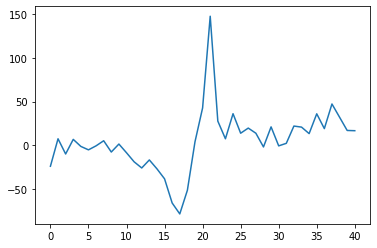

In [12]:
df_abnormal_returns_type.sum(axis=0).plot()

<AxesSubplot:xlabel='Company,i,event_timestamp'>

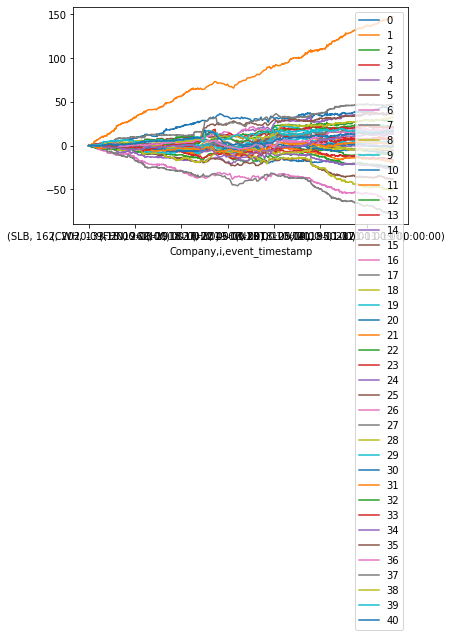

In [13]:
CAR = df_abnormal_returns_type.cumsum(axis=0)
CAR.plot()

![alt text](assets/images/cross_sectional_agg.png)


<AxesSubplot:>

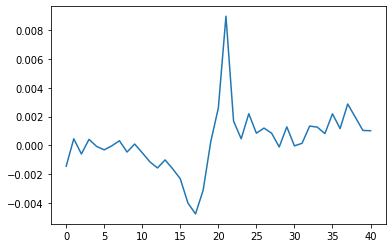

In [14]:
AR_bar = df_abnormal_returns_type.mean(axis=0) 
AR_bar.plot()

In [15]:
CAR_bar = AR_bar.sum()
CAR_bar

0.012431682481465835

In [16]:
# TODO var_CAR_bar = Does the definition make sense? It seems like we take the var of a scalar

![alt text](assets/images/cross_sectional_agg2.png)


In [17]:
CAR_bar_2 = CAR.mean()
CAR_bar_2

0     -9.257976
1      3.336625
2     -3.619453
3      3.648226
4     -1.318272
5     -3.392625
6      0.886245
7      2.926782
8     -1.344457
9      1.930601
10    -3.259918
11    -7.114270
12   -12.225096
13    -8.238810
14   -14.095292
15   -18.254270
16   -33.343385
17   -37.442552
18   -18.542910
19     3.424846
20    26.139611
21    77.882066
22    12.513732
23    -0.665296
24    16.866202
25     9.896657
26    12.349080
27     5.762539
28    -3.357121
29     6.654475
30    -1.427480
31    -1.291546
32    12.509002
33    11.012217
34    -0.174607
35    19.243532
36     5.620693
37    25.847098
38    14.105497
39    11.438981
40     7.382707
dtype: float64

In [18]:
# var car TODO not sure what just sigma means.

# Statistics

Check if CAR mean = 0 (t-test)

In [19]:
# unpickle the data
df_eps = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_eps.pkl")
df_estimation_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_estimation_window_market_return.pkl")
df_event_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_event_window_market_return.pkl")

df_eps.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_estimation_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_event_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)


In [20]:
from source.statistical_tests import grank, adjBMP

In [21]:
df_eps

0         1         2         3   \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30      -0.004953  0.001177 -0.003513  0.003379   
        3  S - Sale  2021-12-21      -0.003938  0.006188  0.004342  0.001892   
        6  G - Gift  2021-12-17       0.006100 -0.007723 -0.003854  0.006375   
        7  S - Sale  2021-12-17       0.006100 -0.007723 -0.003854  0.006375   
        8  S - Sale  2021-12-06      -0.004435  0.026471 -0.005464  0.000396   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31       0.017648  0.001433  0.032413  0.067565   
        78 S - Sale  2018-08-16      -0.003612 -0.012432  0.005989  0.010075   
        79 S - Sale  2018-08-14      -0.007068 -0.010856 -0.003824 -0.012713   
        80 S - Sale  2018-08-07      -0.078127 -0.041390 -0.026901  0.079836   
        81 S - Sale  2018-08-03      -0.023679 -0.027566 -0.077630 -0.040996   

                                            4         5         6         7   \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30       0.003761  0.000548  0.002767 -0.008330   
        3  S - Sale  2021-12-21       0.001084 -0.001957 -0.005775  0.000549   
        6  G - Gift  2021-12-17       0.004856  0.002113  0.001733 -0.002253   
        7  S - Sale  2021-12-17       0.004856  0.002113  0.001733 -0.002253   
        8  S - Sale  2021-12-06      -0.000416  0.003733 -0.008410  0.000291   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31       0.002623  0.038954 -0.000545 -0.003339   
        78 S - Sale  2018-08-16      -0.052419  0.025342  0.002432  0.034215   
        79 S - Sale  2018-08-14       0.005710  0.009804 -0.052649  0.025131   
        80 S - Sale  2018-08-07       0.001448 -0.006435 -0.005933 -0.000506   
        81 S - Sale  2018-08-03      -0.026655  0.079880  0.001559 -0.006190   

                                            8         9   ...        90  \
Company i  TradeType event_timestamp                      ...             
A       2  S - Sale  2021-12-30       0.010317  0.010105  ...  0.022132   
        3  S - Sale  2021-12-21      -0.004233  0.002677  ...  0.025823   
        6  G - Gift  2021-12-17      -0.005600  0.000995  ... -0.002848   
        7  S - Sale  2021-12-17      -0.005600  0.000995  ... -0.002848   
        8  S - Sale  2021-12-06       0.006237  0.005969  ...  0.004613   
...                                        ...       ...  ...       ...   
ZYME    77 S - Sale  2018-08-31      -0.007100 -0.082985  ... -0.058089   
        78 S - Sale  2018-08-16      -0.054037 -0.006232  ... -0.006490   
        79 S - Sale  2018-08-14       0.002202  0.033972  ...  0.014312   
        80 S - Sale  2018-08-07      -0.017372  0.001356  ... -0.068995   
        81 S - Sale  2018-08-03      -0.005439 -0.000105  ... -0.028804   

                                            91        92        93        94  \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30       0.003983  0.005847  0.017307 -0.008626   
        3  S - Sale  2021-12-21      -0.007284 -0.001348 -0.004985  0.009744   
        6  G - Gift  2021-12-17      -0.011068  0.025947 -0.006986 -0.000914   
        7  S - Sale  2021-12-17      -0.011068  0.025947 -0.006986 -0.000914   
        8  S - Sale  2021-12-06       0.000175 -0.001016 -0.012616 -0.002282   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31      -0.011894 -0.026324 -0.016114  0.000201   
        78 S - Sale  2018-08-16      -0.027385 -0.007563 -0.020089  0.001848   
        79 S - Sale  2018-08-14       0.012465 -0.006707 -0.027606 -0.007776   
        80 S - Sale  2018-08-07       0.023179 -0.056685  0.000906  0.006748   
        81 S - Sale  2018-

In [22]:
df_abnormal_returns.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
left, right = investigation_periods["pandemic"]
df_abnormal_returns.loc[:,:,type_, left:right]

0         1         2   \
Company i   TradeType    event_timestamp                                 
AA      85  P - Purchase 2021-01-28      -0.009956  0.028021 -0.004382   
        96  P - Purchase 2020-11-18       0.046922  0.007078 -0.024056   
        97  P - Purchase 2020-10-20       0.034105 -0.002226  0.002032   
        111 P - Purchase 2020-09-18      -0.006218 -0.043435  0.006842   
        112 P - Purchase 2020-08-18       0.018415 -0.015905 -0.021521   
...                                            ...       ...       ...   
YETI    140 P - Purchase 2020-05-12       0.137264 -0.015519  0.016780   
ZBH     12  P - Purchase 2021-05-10      -0.007905  0.001835 -0.003075   
        39  P - Purchase 2020-05-13      -0.003246 -0.004686  0.052050   
ZTS     71  P - Purchase 2021-02-23      -0.011268 -0.007376 -0.027440   
ZYME    53  P - Purchase 2020-04-07      -0.070644 -0.048109 -0.037507   

                                                3         4         5   \
Company i   TradeType    event_timestamp                                 
AA      85  P - Purchase 2021-01-28       0.026979 -0.006329  0.028087   
        96  P - Purchase 2020-11-18       0.004137  0.019188  0.011003   
        97  P - Purchase 2020-10-20      -0.038174  0.020790 -0.034219   
        111 P - Purchase 2020-09-18      -0.013923 -0.009578 -0.024115   
        112 P - Purchase 2020-08-18       0.008082  0.025234 -0.018310   
...                                            ...       ...       ...   
YETI    140 P - Purchase 2020-05-12      -0.064494  0.007594 -0.006136   
ZBH     12  P - Purchase 2021-05-10       0.013758 -0.003233  0.008456   
        39  P - Purchase 2020-05-13       0.003766 -0.016404 -0.042579   
ZTS     71  P - Purchase 2021-02-23       0.015890 -0.004546  0.001778   
ZYME    53  P - Purchase 2020-04-07      -0.055810 -0.076330  0.092397   

                                                6         7         8   \
Company i   TradeType    event_timestamp                                 
AA      85  P - Purchase 2021-01-28      -0.020303 -0.016711 -0.015475   
        96  P - Purchase 2020-11-18       0.015532  0.023363  0.013293   
        97  P - Purchase 2020-10-20      -0.024385 -0.027376  0.031444   
        111 P - Purchase 2020-09-18      -0.000787 -0.020654  0.017359   
        112 P - Purchase 2020-08-18      -0.003234  0.015802 -0.006336   
...                                            ...       ...       ...   
YETI    140 P - Purchase 2020-05-12      -0.026688  0.005964  0.059367   
ZBH     12  P - Purchase 2021-05-10       0.017040  0.006023  0.009554   
        39  P - Purchase 2020-05-13       0.033836  0.022526 -0.011203   
ZTS     71  P - Purchase 2021-02-23       0.005838 -0.015867  0.007813   
ZYME    53  P - Purchase 2020-04-07      -0.055266  0.052201  0.043813   

                                                9   ...        31        32  \
Company i   TradeType    event_timestamp            ...                       
AA      85  P - Purchase 2021-01-28       0.009312  ...  0.000977  0.026414   
        96  P - Purchase 2020-11-18      -0.020427  ...  0.046022 -0.007281   
        97  P - Purchase 2020-10-20      -0.030377  ... -0.067295  0.022358   
        111 P - Purchase 2020-09-18      -0.055976  ... -0.024752 -0.010944   
        112 P - Purchase 2020-08-18       0.041720  ... -0.049074  0.005894   
...                                            ...  ...       ...       ...   
YETI    140 P - Purchase 2020-05-12       0.016491  ... -0.049465  0.003449   
ZBH     12  P - Purchase 2021-05-10      -0.008822  ...  0.003760 -0.024766   
        39  P - Purchase 2020-05-13      -0.027476  ... -0.012364  0.005036   
ZTS     71  P - Purchase 2021-02-23       0.010760  ...  0.001742  0.004514   
ZYME    53  P - Purchase 2020-04-07       0.076674  ... -0.017928  0.023004   

                                                33        34        35  \
Company i   TradeType    event_timestamp                 

In [23]:
test_results = []
test_index = []

for per in investigation_periods.keys():
    for type_ in types_of_interest:
        left, right = investigation_periods[per]
        AR = df_abnormal_returns.loc[:,:,type_, left:right].values
        eps = df_eps.loc[:,:,type_,left:right].values
        R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
        R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
        event_day = 20
        grank_result = grank(AR, eps, R_market_estimation_window, R_market_event_window, event_day)
        adjBMP_result = adjBMP(AR, eps, R_market_estimation_window, R_market_event_window, event_day)
        test_results.append((grank_result.pvalue, adjBMP_result.pvalue))
        test_index.append((per, type_))

In [ ]:
test_results_df = pd.DataFrame(test_results, columns=["GRANK", "adj-BMP"], index=pd.MultiIndex.from_tuples(test_index))
test_results_df.round(5)

In [25]:
tt = stats.ttest_1samp(CAR, popmean=0)
tt

Ttest_1sampResult(statistic=array([-120.30967757,   87.07838564, -133.23551214,  104.50410819,
        -41.3898714 , -160.54237117,   44.57734116,   78.78256219,
        -50.20082256,   86.45406424, -160.7673238 , -172.31481201,
       -264.39954555, -245.20671203, -291.67922268, -213.89989821,
       -275.25146232, -245.55113315, -164.11352663,   47.62183564,
        263.79140498,  252.00778273,  136.94427704,  -15.54797804,
        161.0425271 ,  222.12889772,  212.55926285,  103.52691556,
       -157.92354451,   86.2077681 ,  -66.93755137,  -49.14275042,
        208.32693127,  152.65908937,   -3.03404851,  178.31750399,
        110.92530537,  226.30526192,  185.46392352,  269.97636346,
        187.74542213]), pvalue=array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0

Check if CAR median = 0 (wilcoxon signed rank test)

In [26]:
stats.wilcoxon(CAR)

WilcoxonResult(statistic=array([2.4108661e+07, 3.1177689e+07, 6.0058530e+06, 2.1417523e+07,
       4.1796116e+07, 4.2718750e+06, 4.6325435e+07, 2.7706239e+07,
       3.4913133e+07, 2.2781808e+07, 4.5092500e+06, 2.6079400e+05,
       1.1700000e+04, 1.7823400e+05, 1.2241400e+05, 8.6530000e+03,
       0.0000000e+00, 1.3665000e+04, 3.0000000e+00, 5.0144985e+07,
       1.9902900e+05, 0.0000000e+00, 1.1508503e+07, 5.6518648e+07,
       2.6270850e+06, 9.3000000e+01, 9.1870000e+03, 2.3338698e+07,
       3.2518730e+06, 3.7452898e+07, 3.6964837e+07, 4.0185366e+07,
       1.0468000e+04, 1.0357170e+07, 5.8436299e+07, 2.1754790e+06,
       1.0647829e+07, 1.4097000e+04, 5.6987000e+04, 2.9743000e+04,
       8.6359000e+04]), pvalue=array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 2.28467010e-265, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.000000

In [27]:
types = types
investigation_periods = investigation_periods
multiind_p, data_p = [], []

event_day_ranges = {
    "pre-event": (0,20), # TODO for now we drop the filing day itself
    "post-event": (21,41)
}

tests = {"ttest": lambda x: round(stats.ttest_1samp(x, popmean=0).pvalue, 10),
         "wilcoxon": lambda x: round(stats.wilcoxon(x).pvalue,10)}

aggregation_type = {"name": "cross-sectional", "axis":0}
#aggregation_type = {"name": "through time", "axis":1}

for type_ in types:
    for per in investigation_periods.keys():
        for side in event_day_ranges.keys():
                
            event_day_range = event_day_ranges[side]
            df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]
            per_left, per_right = investigation_periods[per]


            timestamps = df_abnormal_returns_type.index.get_level_values(2)
            mask = (timestamps >= per_left) & (timestamps <= per_right)
            df_AR_type_per = df_abnormal_returns_type[mask]
            if not len(df_AR_type_per):
                print(f"skipping iteration because of 0 datapoints {(type_, per, side)}")
                continue
            df_AR_type_per_side = df_AR_type_per.iloc[:,event_day_range[0]:event_day_range[1]]
            CAR = df_AR_type_per_side.mean(axis=aggregation_type["axis"]).cumsum()

            pvalue_ttest = tests["ttest"](CAR)
            pvalue_wilcoxon = tests["wilcoxon"](CAR)
            mean = CAR.mean()
            median = CAR.median()
            # calculate a 95% confidence interval
            left, right = stats.t.interval(0.95, len(CAR)-1, loc=np.mean(CAR), scale=stats.sem(CAR))
            left, right = round(left, 4), round(right, 4)
            CI = left, right
            
            multiind_p.append((type_, per, side))
            data_p.append((mean, pvalue_ttest, median, pvalue_wilcoxon, len(df_AR_type_per), CI))

In [28]:
# process abnormal returns
df_p = pd.DataFrame.from_records(data_p)
df_p.index = pd.MultiIndex.from_tuples(multiind_p, names=["TradeType", "Period", "Side"])
df_p.columns = ["mean", "ttest pvalue", "median", "wilcoxon pvalue", "sample_size", "95% CI"]
df_p.to_csv(f"data/{NAME}/{aggregation_type['name']}_tests_result.csv")
df_p.sort_values("ttest pvalue")

mean  ttest pvalue    median  \
TradeType           Period       Side                                           
C - Converted deriv pandemic     post-event -0.029641  0.000000e+00 -0.030963   
P - Purchase        pandemic     post-event  0.018565  0.000000e+00  0.018414   
                    overall      post-event  0.019171  1.000000e-10  0.017460   
X - OptEx           pre-pandemic post-event  0.021237  9.000000e-10  0.021803   
P - Purchase        pre-pandemic post-event  0.019501  2.200000e-09  0.017951   
...                                               ...           ...       ...   
X - OptEx           overall      pre-event  -0.003143  2.266623e-01 -0.005141   
W - Inherited       overall      pre-event  -0.000585  6.203090e-01 -0.000083   
X - OptEx           pre-pandemic pre-event  -0.000320  8.549637e-01  0.000711   
D - Sale to issuer  overall      pre-event  -0.000050  8.932021e-01 -0.000171   
W - Inherited       pandemic     pre-event   0.000007  9.971310e-01 -0.001095   

                                             wilcoxon pvalue  sample_size  \
TradeType           Period       Side                                       
C - Converted deriv pandemic     post-event         0.000002          715   
P - Purchase        pandemic     post-event         0.000002         5792   
                    overall      post-event         0.000002        16429   
X - OptEx           pre-pandemic post-event         0.000002          155   
P - Purchase        pre-pandemic post-event         0.000002        10637   
...                                                      ...          ...   
X - OptEx           overall      pre-event          0.132727          249   
W - Inherited       overall      pre-event          0.674223           31   
X - OptEx           pre-pandemic pre-event          0.927279          155   
D - Sale to issuer  overall      pre-event          0.869488         3818   
W - Inherited       pandemic     pre-event          0.985435           16   

                                                        95% CI  
TradeType           Period       Side                           
C - Converted deriv pandemic     post-event  (-0.0343, -0.025)  
P - Purchase        pandemic     post-event   (0.0167, 0.0204)  
                    overall      post-event   (0.0161, 0.0222)  
X - OptEx           pre-pandemic post-event   (0.0173, 0.0252)  
P - Purchase        pre-pandemic post-event   (0.0156, 0.0234)  
...                                                        ...  
X - OptEx           overall      pre-event   (-0.0084, 0.0021)  
W - Inherited       overall      pre-event    (-0.003, 0.0018)  
X - OptEx           pre-pandemic pre-event   (-0.0039, 0.0033)  
D - Sale to issuer  overall      pre-event   (-0.0008, 0.0007)  
W - Inherited       pandemic     pre-event   (-0.0041, 0.0041)  

[66 rows x 6 columns]

In [29]:
df_p.loc["S - Sale"]

mean  ttest pvalue    median  wilcoxon pvalue  \
Period       Side                                                            
overall      pre-event   0.006794  1.398010e-05  0.005864         0.000002   
             post-event -0.008273  2.800000e-08 -0.008103         0.000002   
pre-pandemic pre-event   0.005791  2.367000e-05  0.004802         0.000002   
             post-event -0.005851  5.960000e-08 -0.005598         0.000002   
pandemic     pre-event   0.007907  9.106800e-06  0.007042         0.000002   
             post-event -0.010958  1.790000e-08 -0.010878         0.000002   

                         sample_size              95% CI  
Period       Side                                         
overall      pre-event         30506    (0.0043, 0.0092)  
             post-event        30506  (-0.0102, -0.0063)  
pre-pandemic pre-event         16035     (0.0036, 0.008)  
             post-event        16035  (-0.0073, -0.0044)  
pandemic     pre-event         14471    (0.0051, 0.0107)  
             post-event        14471  (-0.0134, -0.0085)

#### Export information to latex

In [30]:
counter = 0
for t in types:
    counter = counter+1
    #print(t)
    df_ = df_p.loc[t,:,:]
    df_ = df_.rename(columns={'Side of the event': 'Side'
                              , 'mean': 'mean'
                              , 'ttest pvalue': 'ttest'
                              , 'median': 'median'
                              , 'wilcoxon pvalue': 'Wilcoxon'
                              , 'sample_size': 'N'})
    #display(df_)
    
    latex = df_.drop(columns=["95% CI"])\
    .to_latex( column_format="llrrrrr"
              , position="H"
              , label=f"table:t{counter}_hypothesistest"
              , caption= f"Hypothesis tests for type: {t}"
              #, index = False
    )
    print(latex)

C:\Users\Tom\AppData\Local\Temp\ipykernel_33644\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\
C:\Users\Tom\AppData\Local\Temp\ipykernel_33644\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\
C:\Users\Tom\AppData\Local\Temp\ipykernel_33644\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler

\begin{table}[H]
\centering
\caption{Hypothesis tests for type: S - Sale}
\label{table:t1_hypothesistest}
\begin{tabular}{llrrrrr}
\toprule
         &            &      mean &         ttest &    median &  Wilcoxon &      N \\
Period & Side &           &               &           &           &        \\
\midrule
overall & pre-event &  0.006794 &  1.398010e-05 &  0.005864 &  0.000002 &  30506 \\
         & post-event & -0.008273 &  2.800000e-08 & -0.008103 &  0.000002 &  30506 \\
pre-pandemic & pre-event &  0.005791 &  2.367000e-05 &  0.004802 &  0.000002 &  16035 \\
         & post-event & -0.005851 &  5.960000e-08 & -0.005598 &  0.000002 &  16035 \\
pandemic & pre-event &  0.007907 &  9.106800e-06 &  0.007042 &  0.000002 &  14471 \\
         & post-event & -0.010958 &  1.790000e-08 & -0.010878 &  0.000002 &  14471 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Hypothesis tests for type: M - OptEx}
\label{table:t2_hypothesistest}
\begin{tabular}{llrrrrr}


C:\Users\Tom\AppData\Local\Temp\ipykernel_33644\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\
C:\Users\Tom\AppData\Local\Temp\ipykernel_33644\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\


### Visualise CI

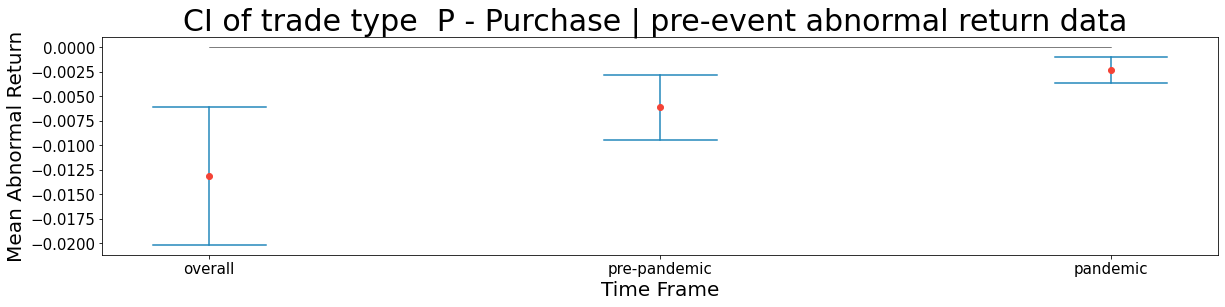

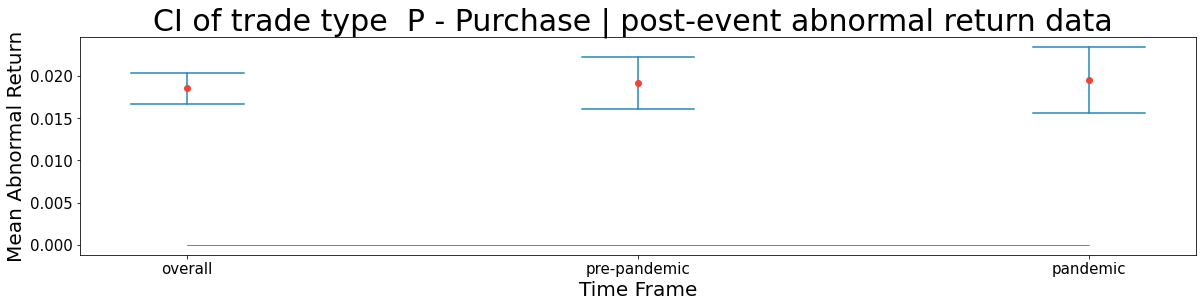

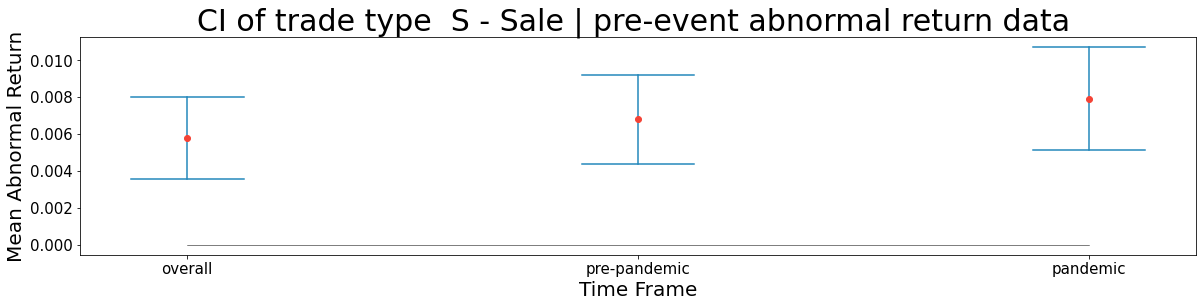

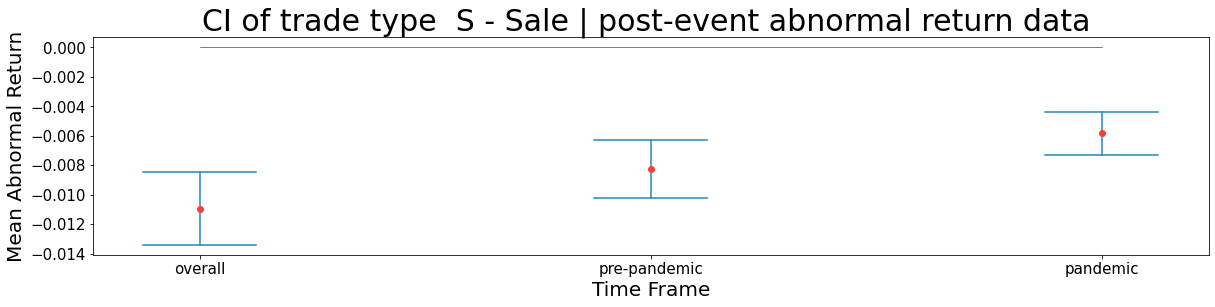

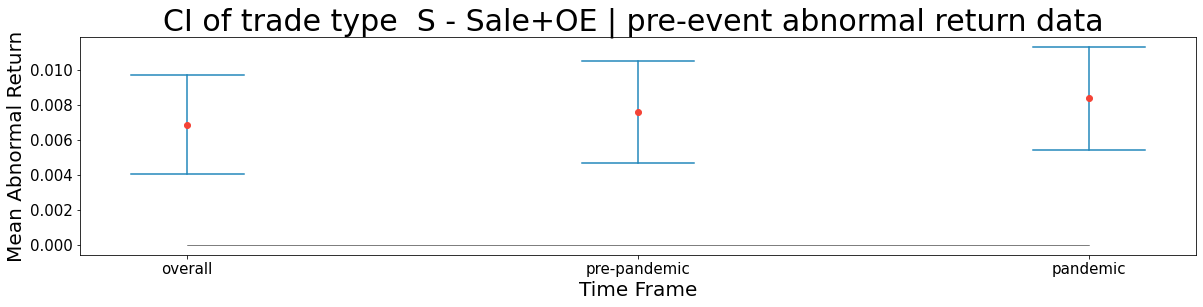

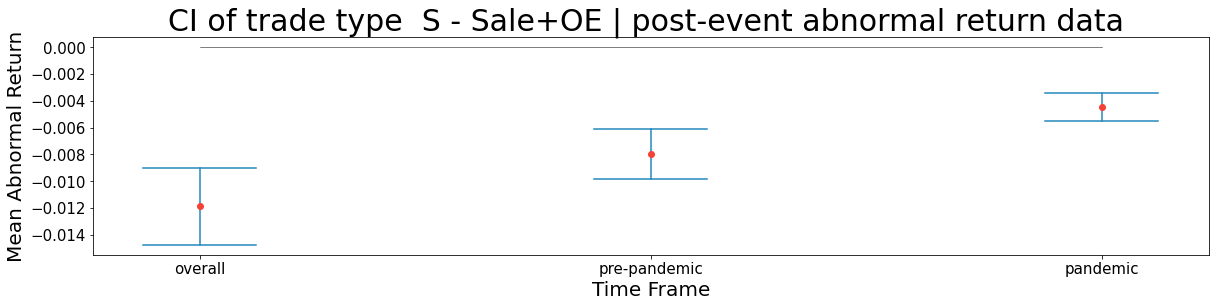

In [31]:
# purcase, sale and sale with oe
for t in types_of_interest:
    for side in event_day_ranges.keys():

        df_ = df_p.loc[t,:,side]

        def plot_confidence_interval(x, mean, CI, color='#2187bb', horizontal_line_width=0.25):


            left = x - horizontal_line_width / 2
            top = mean - CI
            right = x + horizontal_line_width / 2
            bottom = mean + CI
            plt.plot([x, x], [top, bottom], color=color)
            plt.plot([left, right], [top, top], color=color)
            plt.plot([left, right], [bottom, bottom], color=color)
            plt.plot(x, mean, 'o', color='#f44336')

            return mean, CI

        plt.figure(figsize=(fig_height,4))

        df_to_plot = df_
        for i, row in enumerate(df_to_plot.sort_values("mean").itertuples()):
            mean, CI = plot_confidence_interval(i, row[1], row[6][1] - row[1])

        plt.plot(np.zeros(len(df_to_plot)), color="black", linewidth=0.5)
        plt.xticks(range(len(df_to_plot)), df_to_plot.index, fontsize=tick_size)
        plt.yticks(fontsize=tick_size)

        plt.title(f'CI of trade type  {t} | {side} abnormal return data ', fontsize=title_size)

        plt.xlabel('Time Frame', fontsize=label_size)
        plt.ylabel('Mean Abnormal Return', fontsize=label_size)

        plt.xticks(fontsize=tick_size)
        plt.yticks(fontsize=tick_size)
        plt.savefig(f"data/{NAME}/visualisations/CI_{t}_{side}.png", dpi=600, bbox_inches='tight')
        plt.show()

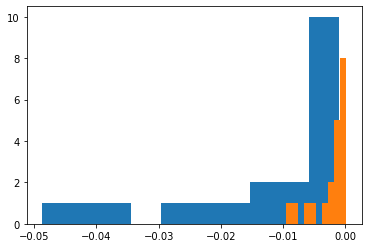

For type P - Purchase, in the days pre-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 0.0030983045


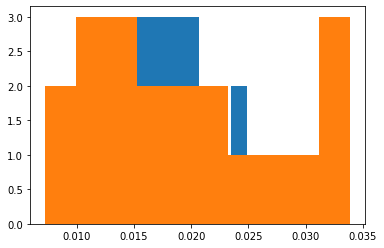

For type P - Purchase, in the days post-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 0.6497859238


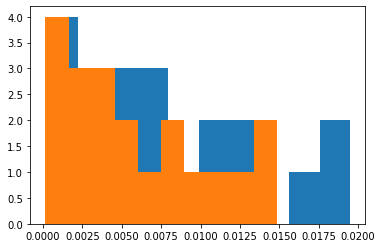

For type S - Sale, in the days pre-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 0.2160139827


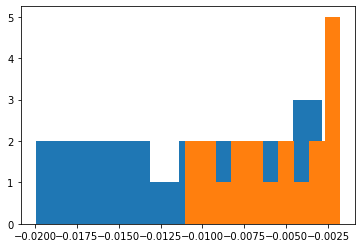

For type S - Sale, in the days post-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 0.0006090072


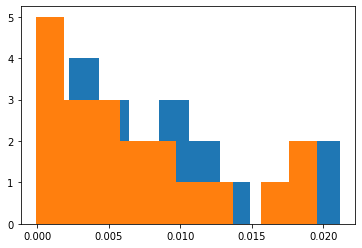

For type S - Sale+OE, in the days pre-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 0.4454840274


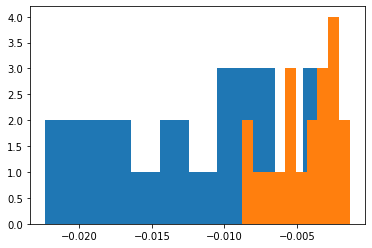

For type S - Sale+OE, in the days post-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 1.03821e-05


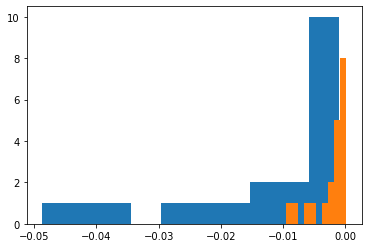

For type P - Purchase, in the days pre-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 9.5367e-06


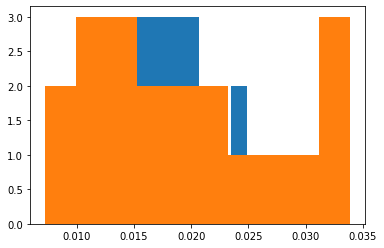

For type P - Purchase, in the days post-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 0.3682765961


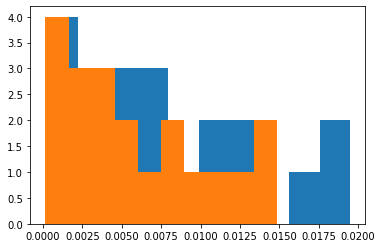

For type S - Sale, in the days pre-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 1.9073e-06


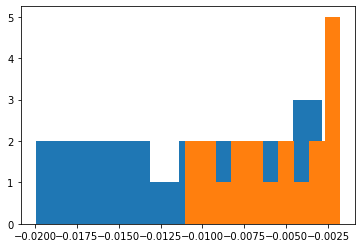

For type S - Sale, in the days post-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 1.9073e-06


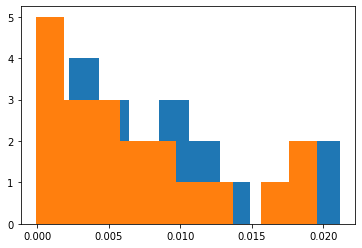

For type S - Sale+OE, in the days pre-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 3.8147e-06


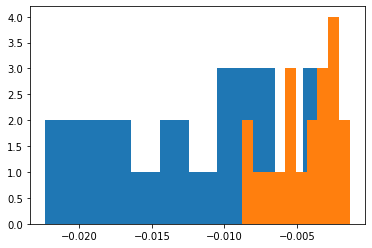

For type S - Sale+OE, in the days post-event of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of 1.9073e-06


In [32]:
multiind_h3, data_h3 = [], []

two_sample_tests = {
    "ttest": lambda x, y: round(stats.ttest_ind(x, y).pvalue, 10),
    "wilcoxon": lambda x, y: round(stats.wilcoxon(x, y).pvalue, 10)
}

for test_name in two_sample_tests.keys():
    for t in types_of_interest:
        d = []
        for side in event_day_ranges.keys():

            event_day_range = event_day_ranges[side]
            df_abnormal_returns_type = df_abnormal_returns.loc[:,:,t]

            timestamps = df_abnormal_returns_type.index.get_level_values(2)

            df_AR_type_side = df_abnormal_returns_type.iloc[:,event_day_range[0]:event_day_range[1]]


            pand_start, pand_end = investigation_periods["pandemic"][0], investigation_periods["pandemic"][1]
            prepand_start, prepand_end = investigation_periods["pre-pandemic"][0], investigation_periods["pre-pandemic"][1]

            mask_pand = (timestamps >= pand_start) & (timestamps <= pand_end)
            mask_prepand = (timestamps >= prepand_start) & (timestamps <= prepand_end)

            df_AR_type_side_pand_agg = df_AR_type_side[mask_pand].mean(axis=0).cumsum()
            df_AR_type_side_prepand_agg = df_AR_type_side[mask_prepand].mean(axis=0).cumsum()
            plt.hist(df_AR_type_side_pand_agg)
            plt.hist(df_AR_type_side_prepand_agg)
            plt.show()

            pvalue = two_sample_tests[test_name](df_AR_type_side_prepand_agg, df_AR_type_side_pand_agg)
            print(f"For type {t}, in the days {side} of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of {pvalue}")

            d.append(pvalue)
        multiind_h3.append((test_name, t))
        data_h3.append(d)

### P-values of whether pre-pandemic and pandemic are significantly different for the timeframe before and after the event and different types

In [33]:
df_h3 = pd.DataFrame(data_h3, columns=event_day_ranges.keys())
df_h3.index=pd.MultiIndex.from_tuples(multiind_h3, names=["Test", "Type"])
df_h3

pre-event  post-event
Test     Type                               
ttest    P - Purchase   0.003098    0.649786
         S - Sale       0.216014    0.000609
         S - Sale+OE    0.445484    0.000010
wilcoxon P - Purchase   0.000010    0.368277
         S - Sale       0.000002    0.000002
         S - Sale+OE    0.000004    0.000002

In [34]:
print(df_h3.to_latex())

\begin{tabular}{llrr}
\toprule
         &             &  pre-event &  post-event \\
Test & Type &            &             \\
\midrule
ttest & P - Purchase &   0.003098 &    0.649786 \\
         & S - Sale &   0.216014 &    0.000609 \\
         & S - Sale+OE &   0.445484 &    0.000010 \\
wilcoxon & P - Purchase &   0.000010 &    0.368277 \\
         & S - Sale &   0.000002 &    0.000002 \\
         & S - Sale+OE &   0.000004 &    0.000002 \\
\bottomrule
\end{tabular}



C:\Users\Tom\AppData\Local\Temp\ipykernel_33644\1013878285.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_h3.to_latex())


Specify the type of the trades to investigate

### Visualize how active Directors Dealings Are
Should move this to somewhere else
Want visual confirmation that Directors have changed behaviour during the times of Covid (Hypothesis 3)

In [ ]:
all_insider_trades = companies[0].insider_data_df.head(0)
from tqdm import tqdm
#for j in tqdm(range(len(companies[:200]))):
for j in tqdm(range(len(companies))):
    all_insider_trades = pd.concat([all_insider_trades, companies[j].insider_data_df])#  @ gunnar very nice asymptotic runtime

 98%|█████████▊| 1505/1534 [00:18<00:00, 37.29it/s]

In [ ]:
all_insider_trades['FilingDateTrunc'] = all_insider_trades['FilingDate'].dt.date
all_insider_trades.groupby('FilingDateTrunc')['FilingDate'].count().plot()

In [ ]:
all_insider_trades.to_csv('AllTradesForExcelGSK.csv')

In [ ]:
all_insider_trades.groupby('FilingDateTrunc')['Value'].sum().plot()

In [ ]:
all_insider_trades.groupby('FilingDateTrunc')['Value'].mean().plot()

In [ ]:
plt.hist(all_insider_trades['FilingDateTrunc'])